# Product Preprocessing strategy

## Downscaling Methodology

Since the Copernicus Data Space Ecosystem (CDSE) does not directly provide TCI products at 60m resolution, we implemented a systematic downscaling workflow:

1. We acquired both L1C (top-of-atmosphere) and L2A (bottom-of-atmosphere) TCI products at their native 10m resolution
2. We applied a bicubic interpolation algorithm for downscaling, which preserves edge and gradient information better than simpler resampling methods
3. This process was applied consistently to both L1C and L2A imagery to maintain paired relationships for the deep learning model

In [2]:
import sys
import os

from dotenv import load_dotenv

import os
import io

from dotenv import load_dotenv
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Now import the module
from auth.auth import S3Connector
from utils.stac_client import get_product_content

load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
DATASET_VERSION = "V2"
BUKETNAME = "eodata"
BANDS = ['TCI']

In [3]:
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
bucket = s3.Bucket(BUKETNAME)

In [4]:
l1c_url_10m = "/Sentinel-2/MSI/L1C/2025/01/01/S2A_MSIL1C_20250101T104441_N0511_R008_T31TFM_20250101T142131.SAFE/GRANULE/L1C_T31TFM_A049769_20250101T104604/IMG_DATA/T31TFM_20250101T104441_TCI.jp2"
l2a_url_10m = "/Sentinel-2/MSI/L2A/2025/01/01/S2A_MSIL2A_20250101T104441_N0511_R008_T31TFM_20250101T163700.SAFE/GRANULE/L2A_T31TFM_A049769_20250101T104604/IMG_DATA/R10m/T31TFM_20250101T104441_TCI_10m.jp2"
l2a_url_60m = "/Sentinel-2/MSI/L2A/2025/01/01/S2A_MSIL2A_20250101T104441_N0511_R008_T31TFM_20250101T163700.SAFE/GRANULE/L2A_T31TFM_A049769_20250101T104604/IMG_DATA/R60m/T31TFM_20250101T104441_TCI_60m.jp2"

In [4]:
import cv2
import numpy as np
from PIL import Image

In [5]:
def get_product(s3_client, bucket_name, object_url, output_path,
                           resize=False, target_size=None, interpolation=cv2.INTER_CUBIC,
                           format='JPEG'):
    """
    Retrieve a satellite image from S3, optionally resize it, and save it.

    Parameters:
    -----------
    s3_client : boto3.client
        Initialized S3 client
    bucket_name : str
        S3 bucket name
    object_url : str
        S3 object key/URL for the image
    output_path : str
        Path where the image should be saved
    resize : bool
        Whether to resize the image (default: False)
    target_size : tuple or None
        Target size as (width, height). Required if resize=True.
    interpolation : int
        OpenCV interpolation method (default: cv2.INTER_CUBIC)
    format : str
        Output image format (default: 'JPEG')

    Returns:
    --------
    str : Path to the saved image
    """
    # Get the image content from S3
    product_content = get_product_content(s3_client=s3_client,
                                          bucket_name=bucket_name,
                                          object_url=object_url)

    # Open as PIL Image
    image = Image.open(io.BytesIO(product_content))

    # Only resize if requested
    if resize:
        if target_size is None:
            raise ValueError("target_size must be specified when resize=True")

        # Convert to numpy array
        image_array = np.array(image)

        # Resize using OpenCV
        resized_array = cv2.resize(image_array, target_size, interpolation=interpolation)

        # Convert back to PIL Image
        image = Image.fromarray(resized_array)

    # Save the image (resized or original) to the specified path
    image.save(output_path, format=format)

    return output_path

In [6]:
resized_path = get_product(
    s3_client=s3_client,
    bucket_name=BUKETNAME,
    object_url=l1c_url_10m,
    output_path="fresized_image_l1c_10m.jpeg",
    resize=True,  # Enable resizing
    target_size=(1830, 1830)  # width, height
)

Successfully downloaded /Sentinel-2/MSI/L1C/2025/01/01/S2A_MSIL1C_20250101T104441_N0511_R008_T31TFM_20250101T142131.SAFE/GRANULE/L1C_T31TFM_A049769_20250101T104604/IMG_DATA/T31TFM_20250101T104441_TCI.jp2


/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [7]:
image_l1c_10m = Image.open(resized_path)

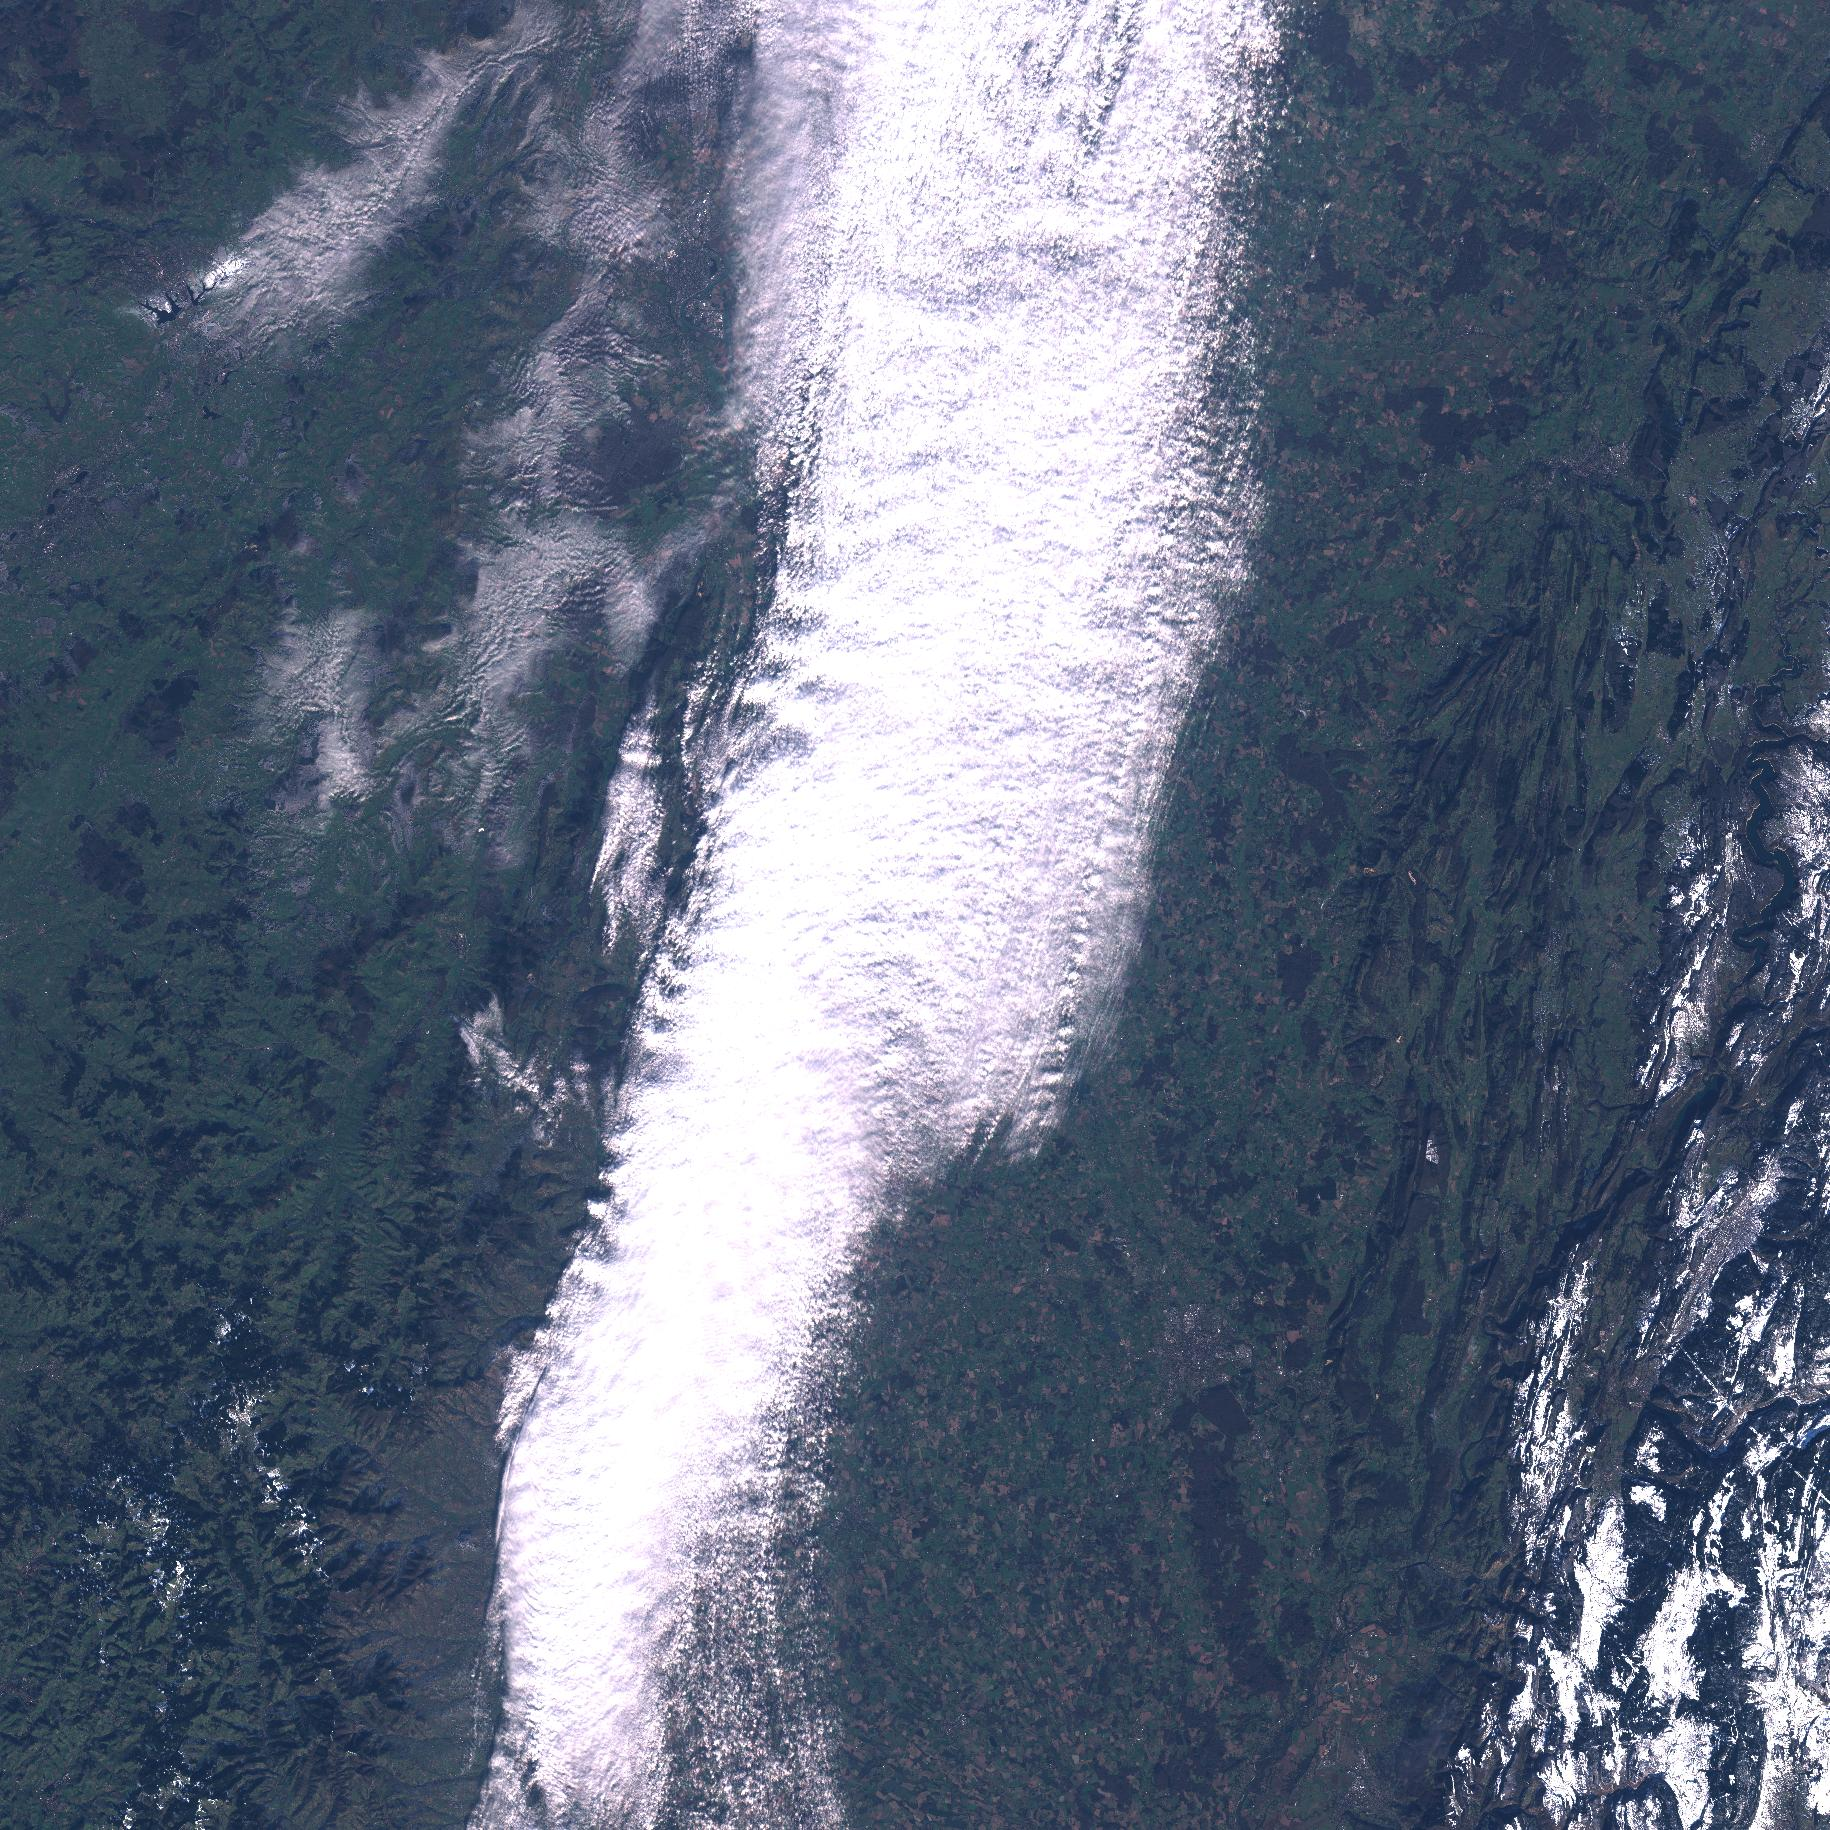

In [8]:
image_l1c_10m